# Computing Depth Maps

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from PIL import Image
import time

# Load the images
def load_image_gray(filepath):
    """Loads an image into a numpy array.
    Note: image will have 3 color channels [r, g, b]."""
    img = Image.open(filepath)
    img = np.asarray(img).astype(float)/255
    if len(img.shape) > 2:
        return img[:, :, 0]
    else:
        return img
    
# Get image patches
def get_patch(image, x, y, patch_half_width):
    return image[y-patch_half_width:y+patch_half_width+1,
                 x-patch_half_width:x+patch_half_width+1]

def patch_match_stereo(image_a, image_b, x_a, y_a,
                       match_score_fn,
                       patch_half_width=9):
    """Returns the location of a feature/patch between stereo images.
    Inputs are the x, y coordinates of the patch in image_a.
    Outputs are the x, y coordinates of the patch in image_b."""

    # (1) Get the patch in image a
    patch_a = get_patch(image_a, x_a, y_a, 
                        patch_half_width=patch_half_width)
    
    # (2) Compute the responses along the epipolar line in image b
    # Define the possible coordinates along with the match might be found
    # (You should feel free to modify this code if you have a simpler
    # way to represent this operation.)
    phw = 8
    xs = range(phw, image_b.shape[1]-phw)
    ys = [y_a] * len(xs)
    possible_coordinates = list(zip(xs, ys))

    if possible_coordinates is None:
        raise NotImplementedError()

    response = np.zeros((len(possible_coordinates)))
    for ind, (x_b, y_b) in enumerate(possible_coordinates):
        # Get the patch
        patch_b = get_patch(image_b, x_b, y_b,
                            patch_half_width=patch_half_width)
        # Compute the match score & store
        response[ind] = match_score_fn(patch_a, patch_b)
    
    # (3) Compute the maximum response
    ind = np.argmax(response)
    x_b, y_b = possible_coordinates[ind]

    return x_b, y_b, response[ind]

def compute_depth_map(image_a, image_b, match_score_fn, phw=8, spacing=15):
    stime = time.time()
    xs = range(phw, image_b.shape[1]-phw, spacing)
    ys = range(phw, image_b.shape[0]-phw, spacing)
    disparity_mat = np.zeros((len(ys), len(xs)))
    responses_mat = np.zeros((len(ys), len(xs)))
    for xi, x_a in enumerate(xs):
        print(f"Progress: {xi}/{len(xs)}")
        for yi, y_a in enumerate(ys):
            x_b, y_b, response = patch_match_stereo(
                image_a, image_b, x_a, y_a, match_score_fn, patch_half_width=phw)
            dx = x_a - x_b
            dy = y_a - y_b
            disparity_mat[yi, xi] = np.sqrt(dx**2 + dy**2)
            responses_mat[yi, xi] = response

    # Compute and threshold the depth map
    depth = 1/(disparity_mat.copy() + 1e-5)
    depth[depth > 0.01] = 0.01
    
    print(f"Time took: {time.time() - stime}")
    return depth



"""
Implemention of the Zero Normalized Cross Correlation algorithm
for computing depth map

Parameters
----------
patch_a: first image patch
patch_b: second image patch

Returns
----------
z: numpy.ndarray
        The image, of the same size as the derivatives, of estimated depths
        at each point

"""

def compute_match_score_zncc(patch_a, patch_b):
    # Compute mean of each patch
    mean_a = np.mean(patch_a)
    mean_b = np.mean(patch_b)

    
    # Compute normalized cross-correlation
    numerator = np.sum((patch_a - mean_a) * (patch_b - mean_b))
    sigmas = np.sqrt(np.sum((patch_a - mean_a)**2)) * np.sqrt(np.sum((patch_b - mean_b)**2))
    
    if sigmas == 0:  # Avoid division by zero
        return 0.0
    else:
        zncc = numerator / sigmas
        return zncc    

In [20]:
# load static parameters manually

# load intrinsic camera matrix
ip = np.array([[2759.48, 0,       1520.69],
               [0,       2764.16, 1006.81],
               [0,       0,       1      ]])


# load external parameters of camera
ep_10 = np.array([[0.70735,   0.706534,   0.0215749 ],
                  [0.0218279, -0.0523403, 0.998391  ],
                  [0.706526,  -0.705741 , -0.0524451]])
ep_09 = np.array([[0.84137,    0.540262,   0.0145864 ],
                  [0.00860137, -0.0403709, 0.999148  ],
                  [0.540391,   -0.840528,  -0.0386139]])
ep_08 = np.array([[0.928942,    0.370116,   0.00895096 ],
                  [0.000956298, -0.0265758, 0.999646   ],
                  [0.370223,    -0.928605,  -0.0250414 ]]) 
ep_07 = np.array([[0.995535,   0.0943815, -0.00170578],
                  [0.003721,  -0.02118,   0.999769   ],
                  [0.0943235, -0.995311,  -0.0214366 ]])
ep_06 = np.array([[0.994915,    -0.100715,  0.00117536],
                  [-0.00462005, -0.0339759, 0.999412  ],
                  [-0.100616,   -0.994335,  -0.0342684]])
ep_05 = np.array([[0.962742,   -0.270399,  0.00344709],
                  [-0.0160548, -0.0444283, 0.998884  ],
                  [-0.269944,  -0.961723,  -0.0471142]])
ep_04 = np.array([[0.890856,   -0.454283,  -0.00158434],
                  [-0.0211638, -0.0449857, 0.998763   ],
                  [-0.453793,  -0.889721,  -0.0496901 ]])
ep_03 = np.array([[0.795163,  -0.606377,  -0.00477103],
                  [-0.050195, -0.0736593, 0.996019   ],
                  [-0.604314, -0.791759,  -0.0890082 ]])
ep_02 = np.array([[0.666779,   -0.74495,   0.021334  ],
                  [-0.0831384, -0.0459057, 0.99548   ],
                  [-0.740603,  -0.665539 , -0.0925429]])
ep_01 = np.array([[0.582226,   -0.813027,  -0.000148752],
                  [-0.0983866, -0.0706383, 0.992638    ],
                  [-0.807052,  -0.577925,  -0.121118   ]])
ep_00 = np.array([[0.450927,   -0.892535,  0.00679989],
                  [-0.0945642, -0.0401974, 0.994707  ],
                  [-0.887537,  -0.449183 , -0.102528 ]])



# load camera positions
cmpos_10 = np.array([-21.9937, -5.82033, -0.0463931])
cmpos_09 = np.array([-20.9553, -4.61897, -0.0303931])
cmpos_08 = np.array([-19.6309, -3.81958, -0.00781603])
cmpos_07 = np.array([-17.6302, -3.36186, 0.0325247])
cmpos_06 = np.array([-15.8818, -3.15083, 0.0592619])
cmpos_05 = np.array([-14.1604, -3.32084, 0.0862032])
cmpos_04 = np.array([-12.404,  -3.81315, 0.110559 ])
cmpos_03 = np.array([-10.8142, -4.53704, 0.122293 ])
cmpos_02 = np.array([-9.46627, -5.58174, 0.147736 ])
cmpos_01 = np.array([-8.31326, -6.3181,  0.16107  ])
cmpos_00 = np.array([-7.28137, -7.57667, 0.204446 ])

# load picture resolution
resolution = (3072, 2048)

# load 3D bounds
bound_10 = ((-20.6108, -7.91985), (-21.9686, -8.77828), (-3.49947, 1.71626))
bound_09 = ((-20.6108, -7.91985), (-21.9686, -8.77828), (-3.49947, 1.71626))
bound_08 = ((-20.9042, -9.85972), (-21.68  , -8.77828), (-6.68267, 1.71626))
bound_07 = ((-21.0826, -12.6952), (-12.6362, -8.77828), (-3.82552, 1.67881))
# wrong bound above
bound_06 = ((-20.6108, -7.91985), (-21.9686, -8.77828), (-3.49947, 1.71626))
bound_05 = ((-20.9042, -9.85972), (-21.68  , -8.77828), (-6.68267, 1.71626))
bound_04 = ((-21.0826, -12.6952), (-12.6362, -8.77828), (-3.82552, 1.67881))
# wrong bound below
bound_03 = ((-20.6108, -7.91985), (-21.9686, -8.77828), (-3.49947, 1.71626))
bound_02 = ((-20.9042, -9.85972), (-21.68  , -8.77828), (-6.68267, 1.71626))
bound_01 = ((-21.0826, -12.6952), (-12.6362, -8.77828), (-3.82552, 1.67881))
bound_00 = ((-21.0826, -12.6952), (-12.6362, -8.77828), (-3.82552, 1.67881))



In [65]:
#load images
def load_image(filepath):
    img = Image.open(filepath)
    return (np.asarray(img).astype(float)/255)[:, :, :3]

img0 = load_image('fountain_dense_images/0000.png')[:, :, 0]
img1 = load_image('fountain_dense_images/0001.png')[:, :, 0]
img2 = load_image('fountain_dense_images/0002.png')[:, :, 0]
img3 = load_image('fountain_dense_images/0003.png')[:, :, 0]
img4 = load_image('fountain_dense_images/0004.png')[:, :, 0]
img5 = load_image('fountain_dense_images/0005.png')[:, :, 0]
img6 = load_image('fountain_dense_images/0006.png')[:, :, 0]
img7 = load_image('fountain_dense_images/0007.png')[:, :, 0]
img8 = load_image('fountain_dense_images/0008.png')[:, :, 0]
img9 = load_image('fountain_dense_images/0009.png')[:, :, 0]
img10 = load_image('fountain_dense_images/0010.png')[:, :, 0]

[[ 9.92656550e-01 -3.78557564e-01  4.99980205e+02]
 [ 1.94261200e-01  1.33534333e+00 -4.72357363e+02]
 [ 1.87720378e-04 -1.70459808e-04  1.00000000e+00]]
[[ 3.64214825e-01  6.74720983e-02  4.47401770e+02]
 [-1.84926577e-01  7.57098844e-01  4.87589392e+02]
 [-1.57150775e-04  5.00175269e-05  1.00000000e+00]]
[[ 3.01701499e-01 -8.22979020e-02  6.22602505e+02]
 [-2.13504332e-01  6.09698367e-01  5.14540017e+02]
 [-1.69251264e-04 -2.27384242e-05  1.00000000e+00]]
[[ 5.42737387e-01 -1.18318154e-01  4.14868257e+02]
 [-1.32547296e-01  7.31463762e-01  3.61916159e+02]
 [-1.10970942e-04 -2.26000781e-05  1.00000000e+00]]
[[ 7.26927239e-01 -2.08026727e-02  2.04014665e+02]
 [-8.80516586e-02  8.96463033e-01  1.45918115e+02]
 [-8.56313422e-05  3.23452280e-05  1.00000000e+00]]
[[ 1.33363044e+00  7.26346277e-02 -1.43638137e+02]
 [ 1.24092774e-01  1.17586520e+00 -2.25832445e+02]
 [ 1.18464753e-04 -6.65036579e-06  1.00000000e+00]]
[[ 1.67144392e+00  1.11362854e-01 -2.96697374e+02]
 [ 2.65583330e-01  1.2813

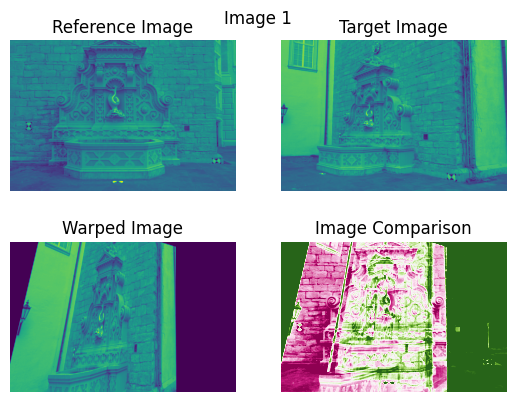

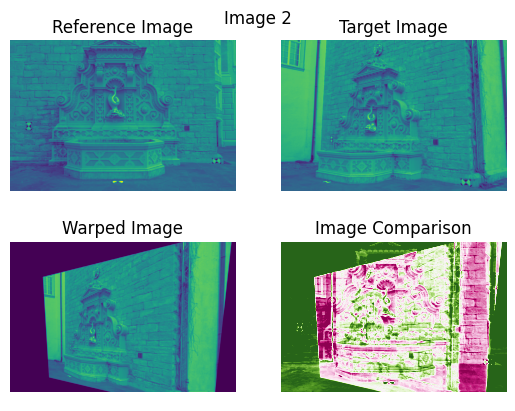

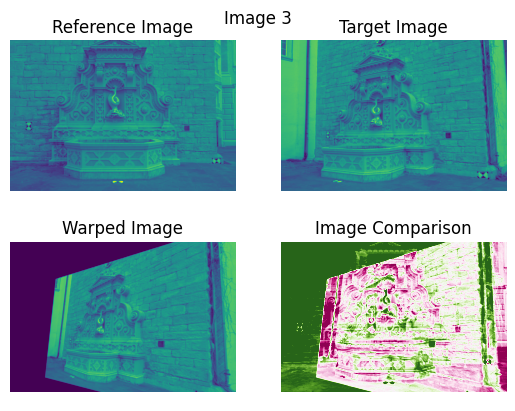

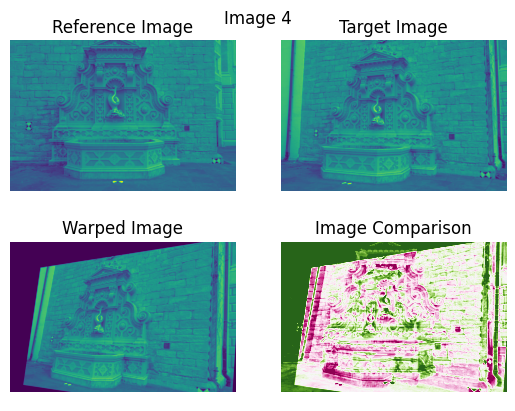

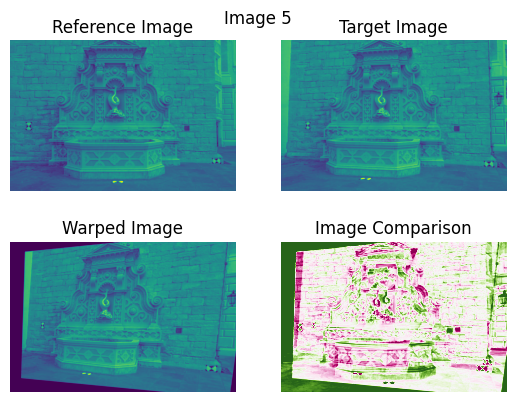

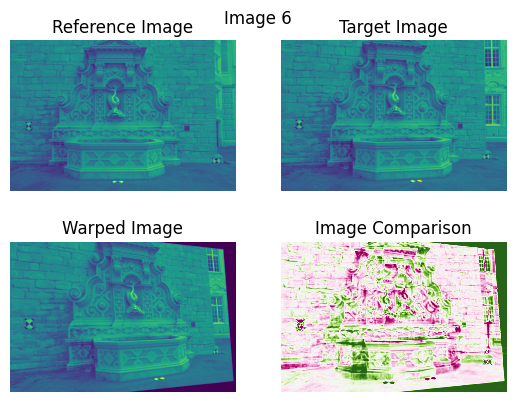

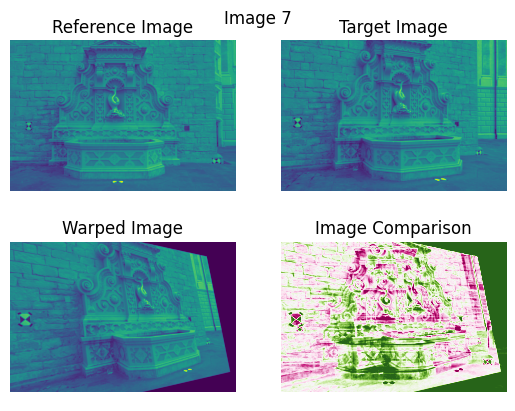

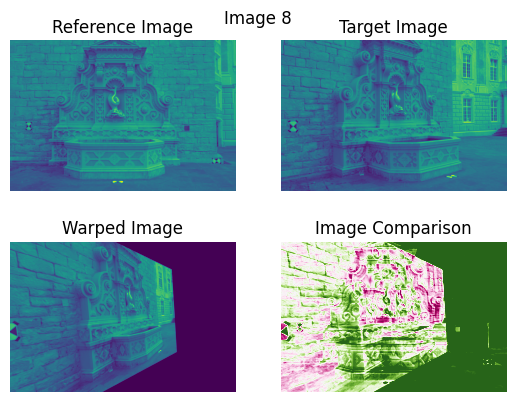

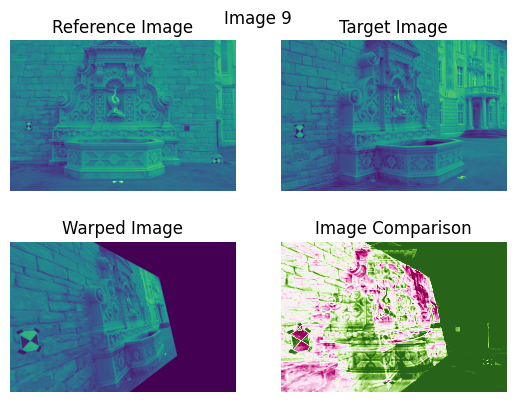

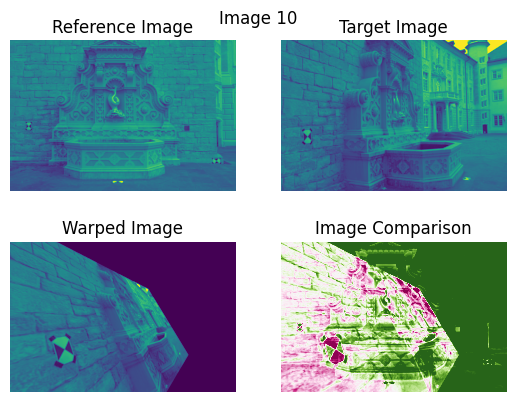

In [78]:
#Compute Homographies

def compute_translation_mat(image_transformed, image_base):
    # From: https://docs.opencv.org/master/d1/de0/tutorial_py_feature_homography.html
    img1 = (image_base*255).astype(np.uint8)
    img2 = (image_transformed*255).astype(np.uint8)
    MIN_MATCH_COUNT = 10
    # Initiate SIFT detector
    sift = cv.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
            
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    H, _ = cv.findHomography(src_pts, dst_pts)
    return H

extrinsic_matrices = [ep_00, ep_01, ep_02, ep_03, ep_04, ep_05, ep_06, ep_07, ep_08, ep_09, ep_10]

imgs = [img0, img1, img2, img3, img4, img5, img6, img7, img8, img9, img10]

positions = [cmpos_00, cmpos_01, cmpos_02, cmpos_03, cmpos_04, cmpos_05, cmpos_06, cmpos_07, cmpos_08, cmpos_09, cmpos_10]

base_camera_matrix = np.dot(ip, extrinsic_matrices[5])

K = ip
K_inv = np.linalg.inv(K)

for i in range(len(imgs)):
    if i == 5:
        continue
    
    H = compute_translation_mat(imgs[i], imgs[5])
    newImg = cv.warpPerspective(imgs[i],H,(resolution[0], resolution[1]),flags=cv.INTER_LINEAR)

    plt.figure()
    plt.axis('off')
    if i >= 5:
         plt.title(f'Image {i}')
    else:
         plt.title(f'Image {i+1}')
    
    plt.subplot(2,2,1)
    plt.axis('off')
    plt.title('Reference Image')
    plt.imshow(img5)
    
    plt.subplot(2,2,2)
    plt.axis('off')
    plt.title('Target Image')
    plt.imshow(imgs[i])
    
    plt.subplot(2,2,3)
    plt.axis('off')
    plt.title('Warped Image')
    plt.imshow(newImg)
    
    plt.subplot(2,2,4)
    plt.axis('off')
    plt.title('Image Comparison')
    plt.imshow(imgs[5] - newImg, vmin=-0.3, vmax=0.3, cmap='PiYG')

